In [3]:
# Computational imports
import numpy as np   # Library for n-dimensional arrays
import pandas as pd  # Library for dataframes (structured data)

# Helper imports
import os 
import warnings
# import pandas_datareader as web
import datetime as dt

# ML/DL imports
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.layers import LSTM, Dense, Dropout, RepeatVector, TimeDistributed,GRU,Embedding
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Plotting imports
import matplotlib.pyplot as plt
import matplotlib.dates as dates
# import plotly.express as px
# import plotly.graph_objects as go
# import plotly.figure_factory as ff
# from plotly.subplots import make_subplots
# from plotly.offline import init_notebook_mode, iplot

# Set seeds to make the experiment more reproducible.
from numpy.random import seed
seed(1)

In [ ]:
filepath='model2/'

In [161]:
df = pd.read_csv('df.csv')

In [162]:
data_oil = pd.read_csv('oil.csv')
data_oil['date']=pd.to_datetime(data_oil['date'])

In [163]:

train_data = pd.read_csv('train.csv', index_col=0)
test_data = pd.read_csv('test.csv', index_col=0)
data_oil = pd.read_csv('oil.csv')
samp_subm = pd.read_csv('sample_submission.csv')
data_holi = pd.read_csv('holidays_events.csv')
data_store =  pd.read_csv('stores.csv')
data_trans = pd.read_csv('transactions.csv')
train_index = len(train_data)
test_index = len(test_data)

C:\Users\User\AppData\Roaming\Python\Python37\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [7]:
# df = pd.concat([train_data,test_data],ignore_index=True)

In [ ]:
# Add holiday into train_data
holi_day = data_holi['date'][data_holi[['date']]['date'].between('2013-01-01','2017-08-31')]
df['date']=pd.to_datetime(df['date'])
df['holiday'] = df['date'].isin(holi_day).replace({True:1,False:0})

In [ ]:
data_day = df.drop_duplicates(['date']).reset_index(drop=True)


In [ ]:

a = [data_oil.index[data_oil['date']==day].tolist() for day in data_day['date']]

In [ ]:
b = [data_day.index[data_day['date']==day].tolist() for day in df['date']]

In [ ]:
data_oil.fillna(value=data_oil['dcoilwtico'].mean(),inplace=True)
df['oil']=data_oil['dcoilwtico'].mean()

In [ ]:
for day_index in range(len(df['oil'])):
    L = a[b[day_index][0]]
    if L!=[]:
        df['oil'][day_index] = data_oil['dcoilwtico'][L[0]]

In [272]:
df.to_csv("df.csv",index=False,sep=',')

In [273]:
object_cols = [cname for cname in df.columns if df[cname].dtype == "object" and cname != "date"]
num_cols = [cname for cname in df.columns if df[cname].dtype in ['int64', 'float64'] ]
all_cols = num_cols + object_cols
print(all_cols)

['store_nbr', 'family', 'sales', 'onpromotion', 'holiday', 'oil']


In [274]:
ordinal_encoder = OrdinalEncoder()
df[object_cols] = ordinal_encoder.fit_transform(df[object_cols])

In [275]:
x_train = df[:train_index].copy()
# y_train = df[:train_index].sales.copy()
x_train = x_train.groupby(['date']).agg({'store_nbr':'mean', 'family':'mean','onpromotion':'mean','holiday':'mean','oil':'mean','sales':'mean'})


In [276]:

scaler = MinMaxScaler(feature_range=(0,1))
all_cols = ["holiday","oil","sales"]

for col in all_cols:
    x_train[col] = scaler.fit_transform(x_train[col].values.reshape(-1,1))
y_train = x_train['sales']
x_train = x_train.drop(columns=['sales'])

In [277]:
history_input = 30
x_train_input = []
y_train_input = []
for i in range(len(x_train)-history_input+1):
    x_train_input.append(x_train[i:i+history_input].values)
    y_train_input.append(y_train.iloc[i+history_input-1])
x_train_input=np.array(x_train_input)
y_train_input=np.array(y_train_input)
# print(x_train_input.shape)
# print(y_train_input.shape)

In [278]:
# def Make_Model_GRU():
#     model = Sequential()
#     model.add(Embedding(3800,32,input_length=380))
#     model.add(Dropout(0.2))
#     model.add(GRU(32))
    
    
    

In [395]:
def Multi_Step_LSTM_model():
    
    # Use Keras sequential model
    model = Sequential()    
    
    # First LSTM layer with Dropout regularisation; Set return_sequences to True to feed outputs to next layer
    model.add(LSTM(units = 50, activation='relu', return_sequences = True, input_shape = x_train_input[0].shape )) 
    model.add(Dropout(0.2))
    
    # Second LSTM layer with Dropout regularisation; Set return_sequences to True to feed outputs to next layer
    model.add(LSTM(units = 50,  activation='relu', return_sequences = True))                                    
    model.add(Dropout(0.2))
    
    # Final LSTM layer with Dropout regularisation; Set return_sequences to False since now we will be predicting with the output layer
    model.add(LSTM(units = 50))
    model.add(Dropout(0.2))
    
    # The output layer with linear activation to predict Open stock price
    model.add(Dense(units=1, activation = "linear"))
    
    return model

In [396]:
model = Multi_Step_LSTM_model()
model.summary()
model.compile(optimizer='adam', loss='mean_squared_error', metrics = ['accuracy'])

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, 30, 50)            11200     
_________________________________________________________________
dropout_18 (Dropout)         (None, 30, 50)            0         
_________________________________________________________________
lstm_19 (LSTM)               (None, 30, 50)            20200     
_________________________________________________________________
dropout_19 (Dropout)         (None, 30, 50)            0         
_________________________________________________________________
lstm_20 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dropout_20 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                

In [397]:
history = model.fit(x_train_input,y_train_input, validation_split=0.3,batch_size=len(x_train_input), epochs=100)

Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 0.2351 - accuracy: 0.0000e+00 - val_loss: 0.3111 - val_accuracy: 0.0000e+00
Epoch 2/100
1/1 [==============================] - 0s 139ms/step - loss: 0.1982 - accuracy: 0.0000e+00 - val_loss: 0.2713 - val_accuracy: 0.0000e+00
Epoch 3/100
1/1 [==============================] - 0s 146ms/step - loss: 0.1685 - accuracy: 0.0000e+00 - val_loss: 0.2347 - val_accuracy: 0.0000e+00
Epoch 4/100
1/1 [==============================] - 0s 152ms/step - loss: 0.1418 - accuracy: 0.0000e+00 - val_loss: 0.1989 - val_accuracy: 0.0000e+00
Epoch 5/100
1/1 [==============================] - 0s 146ms/step - loss: 0.1167 - accuracy: 0.0000e+00 - val_loss: 0.1628 - val_accuracy: 0.0000e+00
Epoch 6/100
1/1 [==============================] - 0s 162ms/step - loss: 0.0919 - accuracy: 0.0000e+00 - val_loss: 0.1244 - val_accuracy: 0.0000e+00
Epoch 7/100
1/1 [==============================] - 0s 152ms/step - loss: 0.0648 - accuracy: 0.0000e+00 - val_

In [398]:
def draw(history):
    val_acc = np.mean(history.history['val_accuracy'])
    print("\n%s: %.2f%%" % ('val_acc', val_acc*100))
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation','train_loss','val_loss'], loc='upper left')

    # plt.legend(['train','loss'], loc='upper left')
    plt.show()


val_acc: 0.00%


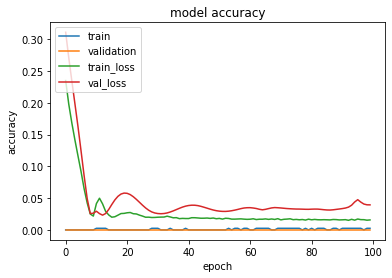

In [399]:
draw(history)
## Perdict

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open(filepath+"model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(filepath+"model.json.h5")
print("Saved model to disk")

In [308]:
x_test_mean = df[train_index:].copy()
x_test_mean = x_test_mean.drop(columns=['sales'])

In [309]:
x_test_mean = x_test_mean.groupby(['date'],as_index=False).agg({'store_nbr':'mean', 'family':'mean','onpromotion':'mean','holiday':'mean','oil':'mean'})

In [310]:
x_test_mean = pd.concat([x_train[-30:-1],x_test_mean],ignore_index=True)

In [363]:
x_test = df[train_index:].copy()
# print(x_test_mean.keys)
# print(pd.concat([x_test_mean[0:29],x_test[0:1]]))
# print(x_test.iloc[0:1])

         store_nbr  family  onpromotion  holiday       oil
1048575        0.0     0.0          0.0      0.0  0.012991


In [370]:
x_test = df[train_index:].copy()
x_test_input = []
for i in range(len(x_test['date'])):
    end = x_test_mean.index[x_test_mean['date']==x_test['date'].iloc[i]].tolist()[0]
    start = end - 29
    x_test_input.append(pd.concat([x_test_mean[start:end].drop(columns=["date"]),x_test[i:i+1].drop(columns=["date","sales"])]).values)
    # print(start,end)
    # if i==28511:
    #     print(x_test_mean[start:end].drop(columns=["date"]),x_test[i:i+1].drop(columns=["date","sales"]))
   
x_test_input=np.array(x_test_input)
print(x_test_input.shape)

    store_nbr  family  onpromotion  holiday       oil
15        0.5     0.5     0.004031      0.0  0.735920
16        0.5     0.5     0.002014      0.0  0.483104
17        0.5     0.5     0.003828      0.0  0.467668
18        0.5     0.5     0.000440      0.0  0.409031
19        0.5     0.5     0.000394      0.0  0.409031
20        0.5     0.5     0.000349      0.0  0.484355
21        0.5     0.5     0.000343      1.0  0.445974
22        0.5     0.5     0.000447      0.0  0.428869
23        0.5     0.5     0.002007      0.0  0.445974
24        0.5     0.5     0.003742      0.0  0.457238
25        0.5     0.5     0.000499      0.0  0.409031
26        0.5     0.5     0.000532      1.0  0.409031
27        0.5     0.5     0.000460      0.0  0.477263
28        0.5     0.5     0.000424      0.0  0.446809
29        0.5     0.5     0.026529      0.0  0.012991
30        0.5     0.5     0.006519      0.0  0.017167
31        0.5     0.5     0.011968      0.0  0.040674
32        0.5     0.5     0.

In [371]:
# x_test_input = x_test_input.
# x_test_input = np.asarray(x_test_input).astype(np.float32)
y_pred = model.predict(x_test_input)
print(y_pred)

In [374]:
y_pred = scaler.inverse_transform(y_pred)
print(y_pred)

In [391]:
test_data = pd.read_csv('test.csv')
submit = test_data[['id']]
submit['sales'] = y_pred
# print(test_data[['id']])

C:\ProgramData\Anaconda3\envs\ProjectPy37\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


<bound method NDFrame.keys of             id       sales
0      3000888  183.252731
1      3000889  183.266754
2      3000890  183.281006
3      3000891  183.293854
4      3000892  183.313461
...        ...         ...
28507  3029395  172.213181
28508  3029396  172.242371
28509  3029397  172.270172
28510  3029398  172.293839
28511  3029399  172.327698

[28512 rows x 2 columns]>

In [394]:
submit.to_csv(filepath+"submit.csv",index=False,sep=',')
import zipfile
with zipfile.ZipFile(filepath+'submit.zip', 'w') as zf:
    zf.write(filepath+'submit.csv')